In [1]:
from util.crossvalidation import cross_test_subject, extract_all_mfcc_features
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data = extract_all_mfcc_features()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

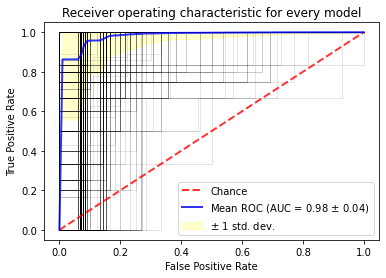

In [28]:
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
fig, ax = plt.subplots()

def test_clf(target_data, other_data, p):
    label = [1]*len(target_data) + [0]*len(other_data)
    data = target_data + other_data
    data = np.array(data)
    label = np.array(label)
    y_test = [0]
    while not any(y_test):
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.35)

    sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
    sgd_clf.fit(X_train, y_train)
    y_pred = sgd_clf.predict(X_test)
    s = sgd_clf.score(X_test, y_test)
    
    #print(f"Score: {s}")
    #print()
    #print("Confusionmatrix:")
    
    mtx = metrics.confusion_matrix(y_test, y_pred)
    try:
        tn, fp, fn, tp = mtx.ravel()
        
    except:
        tn, fp, fn, tp = 1, 0, 0, 1
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    viz = RocCurveDisplay.from_estimator(
        sgd_clf,
        X_test,
        y_test,
        name='_nolegend_',
        alpha=0.1,
        lw=1,
        ax=ax,
        color='black'
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    #metrics.plot_roc_curve(sgd_clf, X_test, y_test)
    return s, mtx, sensitivity, specificity

        
        
clf_data = {'score': [], 'sensitivity': [], 'specificity': []}
c_mtx = np.array([[0,  0],[ 0,  0]])
for X in range(1, 25):
    c = []
    sen = []
    spec = []
    target_data, negative_sets = cross_test_subject(data, X, 100, 36)
    for set in negative_sets:
        s, mtx, sensitivity, specificity = test_clf(target_data, set, X)
        c_mtx += mtx
        c.append(s)
        sen.append(sensitivity)
        spec.append(specificity)
    clf_data['score'].append(c)
    clf_data['sensitivity'].append(sen)
    clf_data['specificity'].append(spec)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="yellow",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic for every model",
)
ax.legend(loc="lower right")
plt.savefig("mean_roc_auc.png", dpi=900)
plt.show()